In [1]:
%matplotlib widget

In [2]:
import numpy as np
from scipy.constants import c as clight
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('pimms_02_tuned.json')
line.build_tracker()
tw = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Build a matched beam distribution

In [4]:
num_particles = 3000
beam_intensity = 1e10 # p+

# Generate Gaussian distribution in normalized phase space
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

# Generate Gaussian momentum distribution (rms spread 5e-4)
delta = 5e-4 * np.random.normal(size=num_particles)

# Particles arrival time spread over one turn
zeta = np.random.uniform(size=num_particles) * line.get_length()

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    zeta=zeta,
    method='4d',
    weight=beam_intensity / num_particles,
    nemitt_x=1.5e-6, nemitt_y=1e-6,
)

# save initial state
p0 = particles.copy()

### Define time-dependent bevior of extraction sextupoles

In [5]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.1e-3, 0.5e-3], y=[0, 0, 1.])

line.vars['kse1'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])
line.vars['kse2'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])

# Inspect the expression
line.vars['kse1']._expr

(4.679345101151352 * f['fun_xsext'](vars['t_turn_s']))

### Set realistic septum aperture

In [6]:
line['septum_aperture'].max_x = 0.035

### Switch to multithreaded context to gain speed

In [7]:
line.discard_tracker()
ctx = xo.ContextCpu(omp_num_threads='auto')
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Define quantities to be logged during tracking

User can provide arbitrary functions executed at every turn (output is automatically logged).

In [8]:
# User-defined quantity to be logged
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

log = xt.Log('kse1', 'kse2',              # vars to be logged
             intensity=measure_intensity) # user-defined function to be logged

### Enable time-dependent vars update for tracking

In [9]:
line.enable_time_dependent_vars = True

### Track!

In [10]:
line.track(particles, num_turns=5000, with_progress=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

### Plot logged quantities

Text(0, 0.5, 'Intensity [$p^+$]')

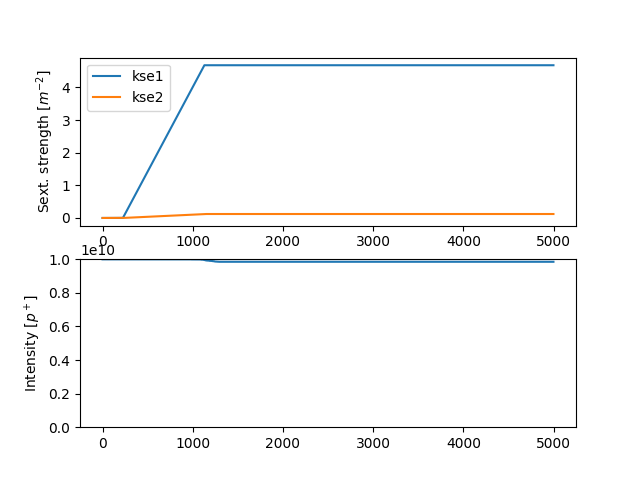

In [11]:
plt.figure()

ax1 = plt.subplot(2,1,1)
plt.plot(line.log_last_track['kse1'], label='kse1')
plt.plot(line.log_last_track['kse2'], label='kse2')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')

### Plot particles after tracking

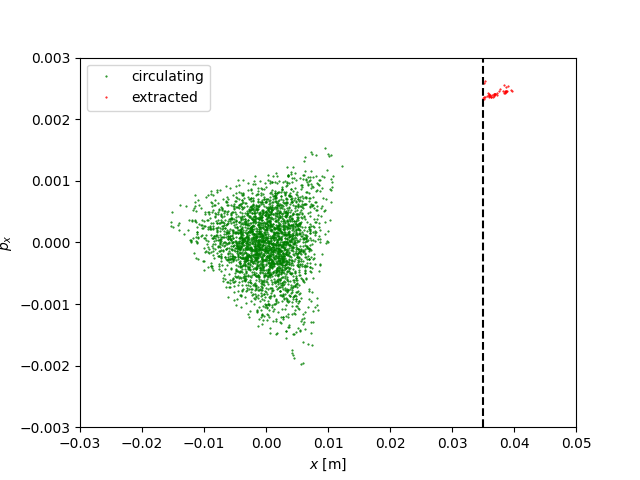

In [12]:
plt.figure()
mask_alive = particles.state>0
mask_lost = ~mask_alive
plt.plot(particles.x[mask_alive], particles.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
plt.plot(particles.x[mask_lost], particles.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
plt.xlabel('$x$ [m]'); plt.ylabel('$p_x$')
plt.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
plt.xlim(-0.03, 0.05); plt.ylim(-3e-3, 3e-3)
plt.legend()
plt.show()

### Introduce transverse excitation to control the spill

We build a custom beam element that excites the beam with a sinusoidal function **of time**

In [13]:
# Define new element type
class SpillExcitation:
    def __init__(self):
        
        self.amplitude = 0
        self.tune = 0
        self.f_rev = 1 / tw.T_rev0

    def track(self, p):

        f_excit = self.tune * self.f_rev

        # Time of arrival corrected for delay within the turn
        t_particle_pass = (p.at_turn[p.state > 0] / self.f_rev
                              - p.zeta[p.state > 0] / p.beta0[0] / clight)

        p.px[p.state > 0] += (
            self.amplitude * np.sin(2 * np.pi * f_excit * t_particle_pass))
        

In [14]:
# Install the element
line.discard_tracker()
line.insert_element('spill_exc', SpillExcitation(), at_s=0)
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Use the amplitude and the frequency of the excitation to control the spill

In [15]:
line.functions['fun_excit'] = xt.FunctionPieceWiseLinear(
    x=[0, 0.5e-3, 0.7e-3,    4e-3],
    y=[0, 0,       1e-5,   3.2e-5])
line.functions['fun_freq'] = xt.FunctionPieceWiseLinear(
    x=[0,     0.5e-3, 1.5e-3,  4e-3],
    y=[0.6615 ,0.6615,  0.6617, 0.6622])

line.vars['ampl_excit'] = line.functions['fun_excit'](line.vars['t_turn_s'])
line.vars['freq_excit'] = line.functions['fun_freq'](line.vars['t_turn_s'])

line.element_refs['spill_exc'].amplitude = line.vars['ampl_excit']
line.element_refs['spill_exc'].tune = line.vars['freq_excit']

### Reset the model

In [16]:
# Reset simulation time
line.vars['t_turn_s'] = 0

In [17]:
# Back to initial particles distribution
p = p0.copy()

### Log excitation parameters

In [18]:
log = xt.Log(
    'kse1', 'kse2', 't_turn_s', # vars to be logged
    'ampl_excit', 'freq_excit',
    intensity=measure_intensity)       # user-defined functions to be logged

### Track

In [19]:
line.track(p, num_turns=6000, with_progress=True,
           log=log)

Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Plot logged quantities

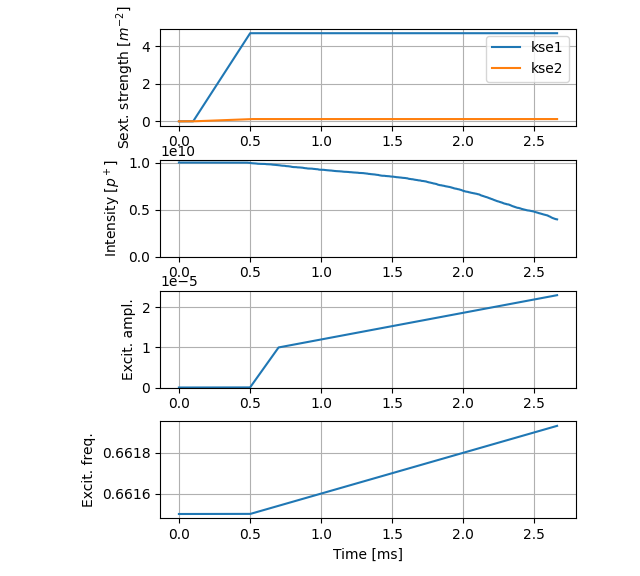

In [20]:
plt.figure(figsize=(6.4, 4.8*1.2))

t_ms = np.array(line.log_last_track['t_turn_s']) * 1e3

ax1 = plt.subplot(4,1,1)
plt.plot(t_ms, line.log_last_track['kse1'], label='kse1')
plt.plot(t_ms, line.log_last_track['kse2'], label='kse2')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()
plt.grid()

ax2 = plt.subplot(4,1,2, sharex=ax1)
plt.plot(t_ms, line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')
plt.grid()

ax3 = plt.subplot(4,1,3, sharex=ax1)
plt.plot(t_ms, line.log_last_track['ampl_excit'])
plt.ylim(bottom=0)
plt.ylabel('Excit. ampl.')
plt.grid()

ax3 = plt.subplot(4,1,4, sharex=ax1)
plt.plot(t_ms, line.log_last_track['freq_excit'])
plt.ylabel('Excit. freq.')
plt.xlabel('Time [ms]')
plt.grid()

plt.subplots_adjust(top=.95, bottom=.1, left=.25, hspace=.35)

### Plot particles after tracking

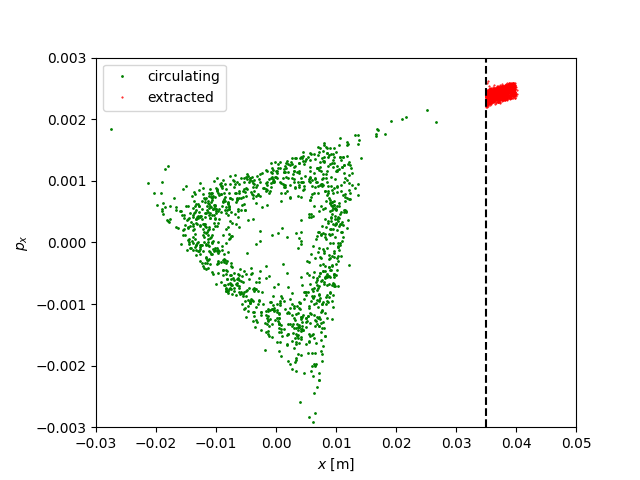

In [21]:
plt.figure()
mask_alive = p.state>0
mask_lost = ~mask_alive
plt.plot(p.x[mask_alive], p.px[mask_alive],
         '.', markersize=2, color='green', label='circulating')
plt.plot(p.x[mask_lost], p.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
plt.xlabel('$x$ [m]'); plt.ylabel('$p_x$')
plt.xlim(-0.03, 0.05); plt.ylim(-3e-3, 3e-3)
plt.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
plt.legend()
plt.subplots_adjust(left=0.15)
plt.show()